In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx

In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

Ith = 1.0  # information threshold


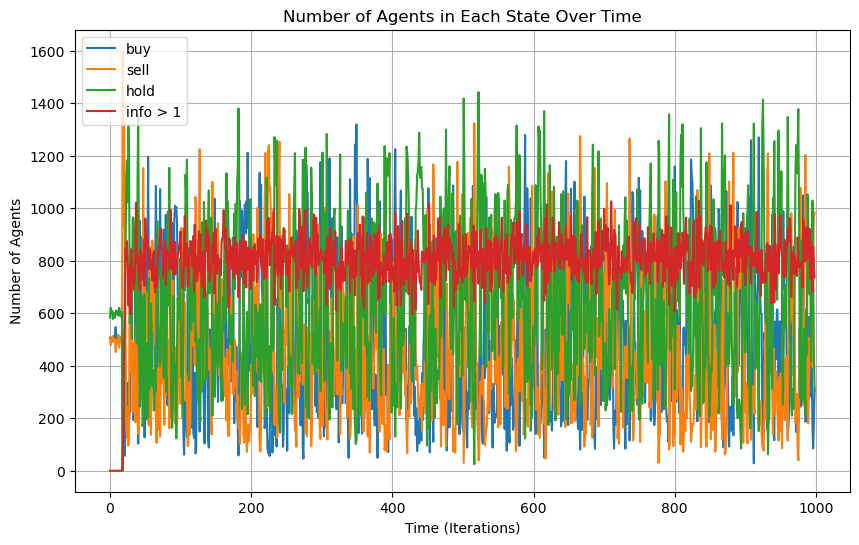

In [63]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100

def propagate_info(agent_index, agents, network, ALPHA, Ith, info_counts):
    agent = agents[agent_index]
    neighbors = list(network.neighbors(agent_index))
    info_count = info_counts[-1]
    if agent['info'] >= Ith:
        N_nn = len(neighbors)
        for neighbor in neighbors:
            agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)
            if agents[neighbor]['info'] >= Ith:
                info_count += 1
                agents[neighbor]['decision'] = agent['decision']
                agent['info'] = 0
                info_counts[-1] = info_count
                propagate_info(neighbor, agents, network, ALPHA, Ith, info_counts)  # Recursive call


# Simulate market dynamics
for t in range(1, 1000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        if agent['info'] > 1:
            info_count += 1  # Increment the counter if this agent's info > 1

        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
        actual_price = 100
            
            
    info_counts.append(info_count)  # Add the count to the list

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
    
    
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        propagate_info(i, agents, network, ALPHA, Ith, info_counts)

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

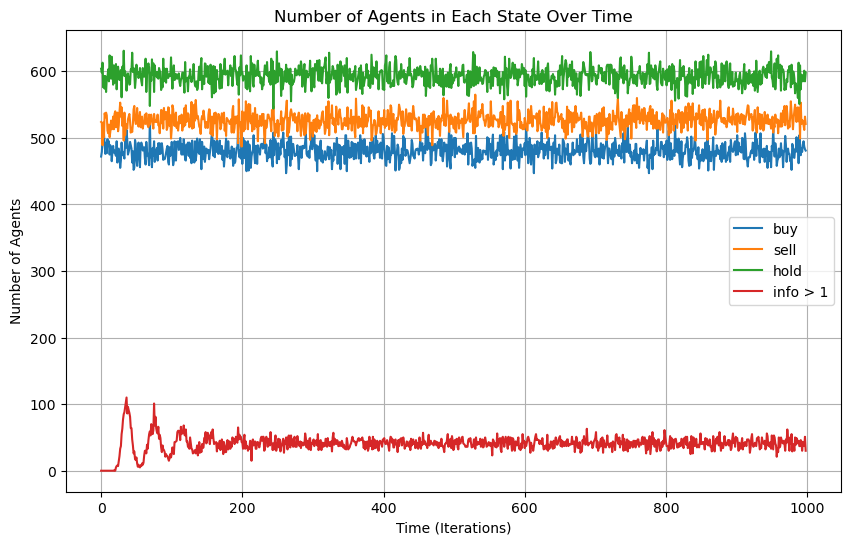

In [61]:


# Create a 2D lattice network 
lattice = nx.grid_2d_graph(40, 40)

# Convert the 2D lattice network to a list of edges
edges = list(lattice.edges())

# Create a Small World network from the 2D lattice network
network = nx.Graph()
network.add_nodes_from(range(N))  # Add nodes
for edge in edges:
    # Add edges with a probability of 0.02
    if np.random.uniform() < 0.02:
        network.add_edge(*edge)

# Create network
# network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100
ALPHA = 0.95

# Adjust the count method of the propagate_info function             
def propagate_info(agent_index, agents, network, ALPHA, Ith, info_counts):
    agent = agents[agent_index]
    if agent['info'] >= Ith:
        info_counts[-1] += 1  # Increment the counter if this agent's info > 1
        neighbors = list(network.neighbors(agent_index))
        N_nn = len(neighbors)
        for neighbor in neighbors:
            agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)
            if agents[neighbor]['info'] >= Ith:
                agents[neighbor]['decision'] = agent['decision']
                agent['info'] = 0
                propagate_info(neighbor, agents, network, ALPHA, Ith, info_counts)  # Recursive call


# Simulate market dynamics
for t in range(1, 1000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_counts.append(0)  # Add a new count for this time step
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
        actual_price = 100

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
            
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        propagate_info(i, agents, network, ALPHA, Ith, info_counts)

    # Reset the info of all agents to 0 after the propagation
    for agent in agents:
        if agent['info'] >= Ith:
            agent['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()
